# House Prices: Advanced Regression Techniques

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn_pandas
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

## Reading CSV file

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
data = pd.concat([train_df.iloc[:,:], test_df.iloc[:,:]])

In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


## EDA

In [6]:
train_df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='SalePrice'>

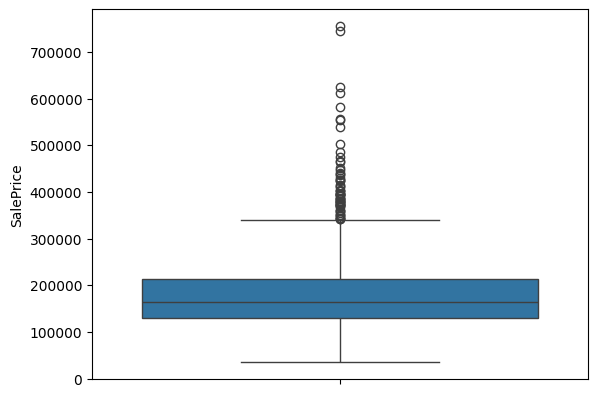

In [7]:
sns.boxplot(train_df.SalePrice)

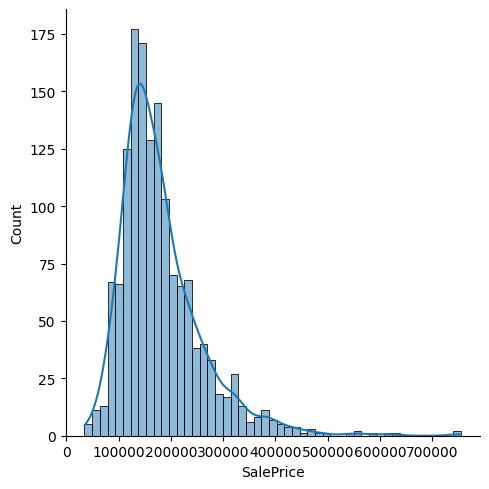

In [8]:
sns.displot(train_df.SalePrice, kde=True)

In [9]:
train_df.SalePrice.skew()

1.8828757597682129

In [10]:
train_df.SalePrice = np.log1p(train_df.SalePrice)

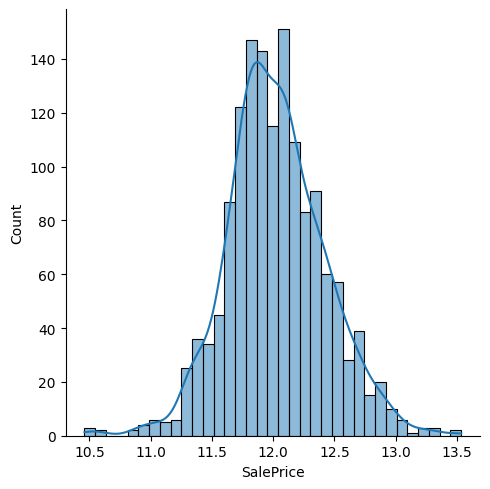

In [11]:
sns.displot(train_df.SalePrice, kde=True)

In [12]:
y_train = train_df.SalePrice

## Nan values columns

In [13]:
null_col = train_df.isna().sum()/len(train_df)

<Axes: >

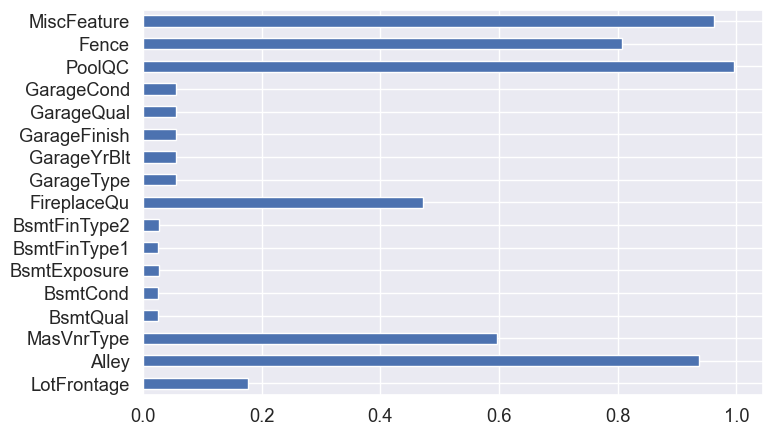

In [14]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
null_col[null_col > 0.01].plot(kind = "barh")

### Removing Id column

In [15]:
train_df = train_df.drop("Id", axis = 1)
test_df = test_df.drop("Id", axis = 1)

### Removing columns that contain the same value

According to basic statistics provided on Kaggle competiton website, the columns Street and Utilities contain only one value "Pave" and "AllPub" respectively.

In [16]:
data_df = train_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

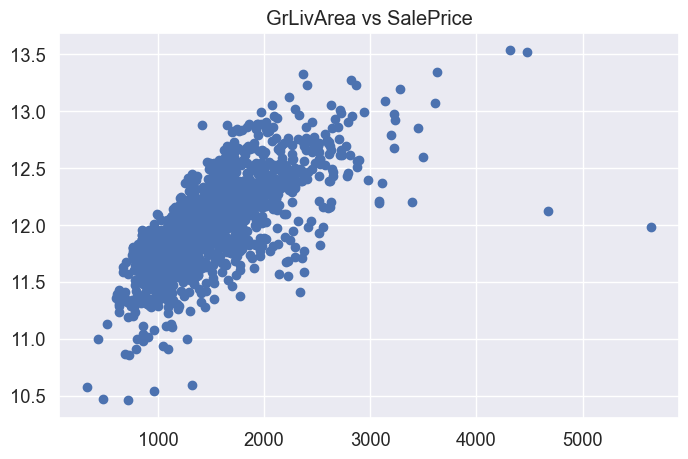

In [18]:
plt.figure(figsize=(8, 5))
plt.scatter(train_df["GrLivArea"], train_df["SalePrice"])
plt.title("GrLivArea vs SalePrice")

In [19]:
clear_data = train_df.drop(train_df[(train_df['GrLivArea']>4500)].index)

In [20]:
train_ = clear_data.drop(['SalePrice'], axis=1)
df = pd.concat([train_df, test_df]).reset_index(drop=True)

### GarageYrBlt feature

In [21]:
print("Is there YearBuilt more than 2017 ? : ", df[df.YearBuilt > 2017].count()[0] != 0)
print("Is there GarageYrBlt more than 2017 ? : ", df[df.GarageYrBlt > 2017].count()[0] != 0)

Is there YearBuilt more than 2017 ? :  False
Is there GarageYrBlt more than 2017 ? :  True


In [22]:
df[df.GarageYrBlt > 2017].GarageYrBlt

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [23]:
df.loc[2590, 'GarageYrBlt'] = 2007

### LotFrontage feature

In [24]:
neigh_lot_frontage = df.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [25]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

### Transformation of some numerical variables that are actually categorical.

In [26]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [27]:
num_to_categ_features = ['MSSubClass', 'OverallCond']

In [28]:
df = convert_to_string(df, columns = num_to_categ_features)

### Replacing missing values in the rest of numerical columns

In [29]:
num_features = df.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [30]:
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'median', 
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'constant',
                                                         'fill_value' : 0, 
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

imputed_median = missing_val_imputer.fit(df)

imputed_features = imputed_median.transform(df)

imputed_df = pd.DataFrame(imputed_features, index=df.index, columns=num_features_to_median + num_features_to_constant)

### Categorical to numeral

In [31]:
cat_feats = df.select_dtypes(include=['object']).columns

In [32]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]

In [34]:
def none_transform(df, conversion_list):
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [35]:
df = none_transform(df, none_conversion)

In [36]:
len(df.columns)

80

### Transformation of skewed features

In [37]:
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']] 

skewed_features = df[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [38]:
lambda_ = 0.15
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], lambda_)

### Categorical into Numerical

In [39]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

In [40]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])

In [46]:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = df[order_feats + ['Neighborhood']]

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

cols = ["Neighborhood"] + order_feats

transformed_feats = label_encoder.fit_transform(df)

transformed_df = pd.DataFrame(transformed_feats, index=df.index, columns=cols)

In [47]:
original_features_df.shape

(2919, 10)

In [48]:
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(df.columns))
rest_features_df = df[list(rest_features)]

In [49]:
df = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)

In [50]:
df.shape

(2919, 80)

## Feature Engineering

### Creating new features

In [51]:
df["TotalSqrtFeet"] = df[["GrLivArea", "TotalBsmtSF"]].sum(axis=1)

df["TotalBaths"] = (df["BsmtFullBath"] + df["BsmtHalfBath"] * 0.5 +
                    df["FullBath"] + df["HalfBath"] * 0.5)

In [52]:
df[['Isgarage', 'Isfireplace', 'Ispool', 'Issecondfloor', 'IsOpenPorch', 'IsWoodDeck']] = df[
    ['GarageArea', 'Fireplaces', 'PoolArea', '2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF']
].applymap(lambda x: 1 if x > 0 else 0)

### One-hot encoding

In [53]:
df = df.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(df).reset_index(drop=True)
hot_one_features.shape

(2919, 328)

In [54]:
df = pd.concat([transformed_df, hot_one_features],axis=1)

### Splitting into train/test

In [55]:
train_preprocessed = df.iloc[:len(data_df),:]
test_preprocessed = df.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


# Modelization

In [56]:
X_train = train_preprocessed

### Scoring function

In [57]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = 1, n_jobs=2))
    return(np.mean(rmse_score))

### Linear Regression

In [54]:
lr_model = make_pipeline(RobustScaler(), LinearRegression())

lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))

Mean Squared Error = 0.00853318


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for Linear Regression: 0.160


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.6s finished


Text(0.5, 1.0, 'Prices vs. Predicted Prices')

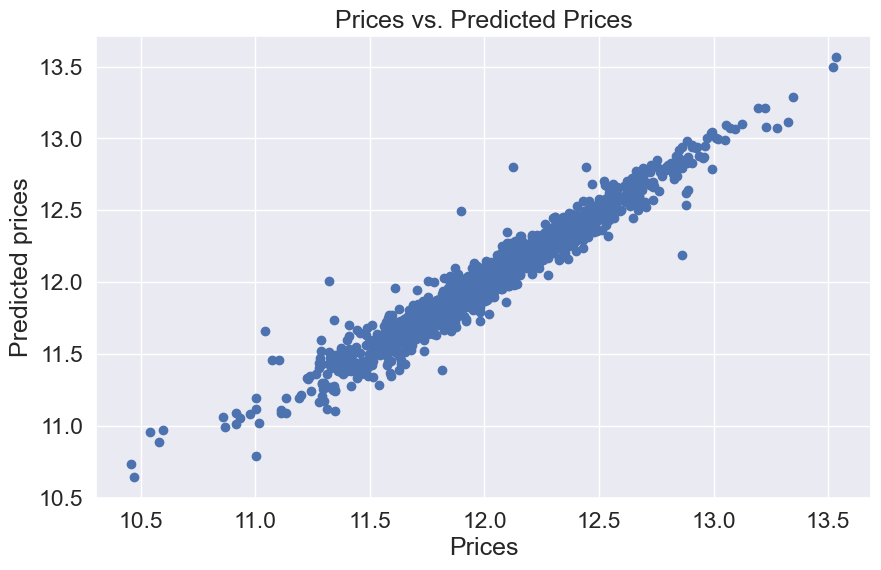

In [55]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
plt.scatter(y_train, y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")

Text(0, 0.5, 'Residuals')

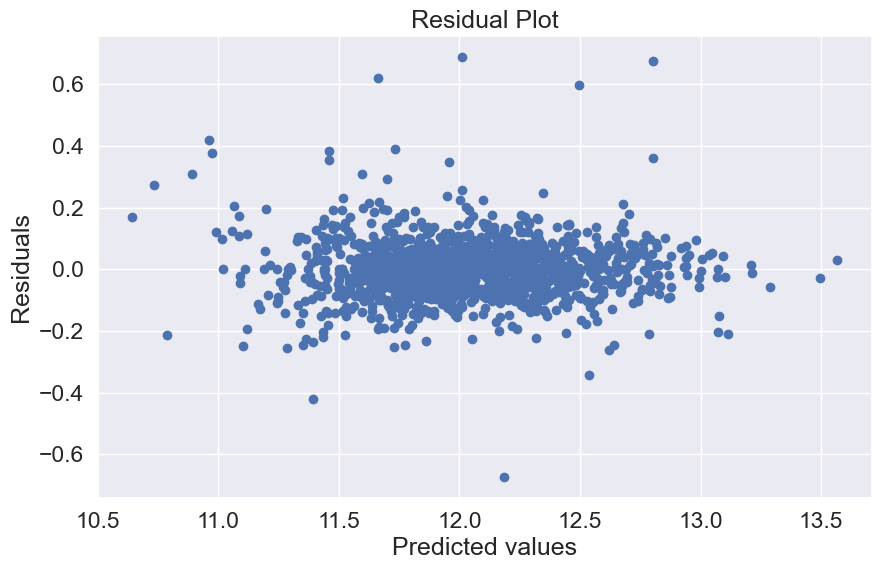

In [56]:
plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")

### LASSO model

In [57]:
lasso_model = make_pipeline(RobustScaler(), 
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(rmse(lasso_model)))

Mean Squared Error = 0.01197439


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for LASSO: 0.135


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.9s finished


<function matplotlib.pyplot.show(close=None, block=None)>

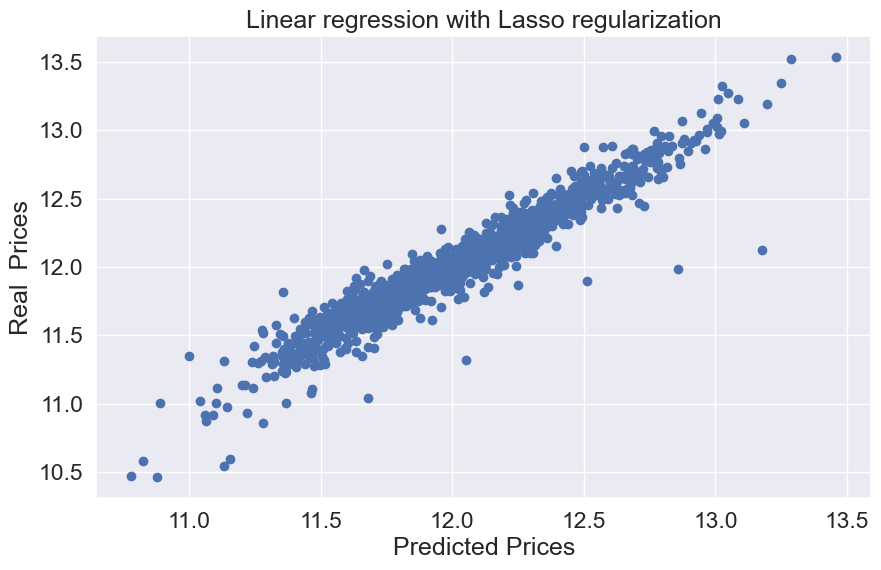

In [58]:
plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("Real  Prices")
plt.show

### Gradient Boosting Regressor

In [59]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}
                              
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [60]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00000929


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for GB: 0.122


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   42.3s finished


### XGB Regressor

In [61]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000], 
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))



Best Parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.8}
Mean Squared Error = 0.00049777


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for XGB: 0.119


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  7.8min finished


### ElasticNet

In [62]:
en_model = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0004, 0.0006], 
                        l1_ratio = [.9, .92], 
                        random_state = 0,
                        cv=10)

In [63]:
en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

In [64]:
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for ElasticNet: {:.3f}".format(rmse(en_model)))

Mean Squared Error = 0.01171991


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RMSE score for ElasticNet: 0.136


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    6.1s finished


### LightGBM

In [ ]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

### Stacking

In [71]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

In [108]:
elasticnet_model = make_pipeline(RobustScaler(), 
                           ElasticNetCV(alphas=[0.0005], 
                                        cv=5, l1_ratio=0.9))

lgbm_model = make_pipeline(RobustScaler(),
                        lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=800,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.23,
                                      feature_fraction_seed = 9, bagging_seed=9,
                                      min_data_in_leaf = 6, 
                                      min_sum_hessian_in_leaf = 11))

xgboost_model = make_pipeline(RobustScaler(),
                        xgb.XGBRegressor(learning_rate = 0.01, n_estimators=3400, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))

In [109]:
stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model, lgbm_model), 
                               meta_regressor=xgboost_model, use_features_in_secondary=True)

### Running

In [ ]:
stack_model = stack_regressor.fit(np.array(X_train),  np.array(y_train))

In [111]:
en_preds = en_model.predict(test_preprocessed)

In [ ]:
stack_gen_preds = stack_model.predict(test_preprocessed)

In [ ]:
lgbm_preds = lgb_model.predict(test_preprocessed)

In [114]:
stack_preds = ((0.3*en_preds) + (0.25*lgbm_preds) + (0.45*stack_gen_preds))

In [115]:
predictions_df = pd.DataFrame(np.expm1(stack_preds), 
                              index = test_preprocessed.index+1, 
                              columns=["SalePrice"])
predictions_df.index.name = "Id"
predictions_df.head()

,SalePrice
Id,
1461,121863.059292
1462,159410.426503
1463,179434.120783
1464,194215.390082
1465,188793.381026


In [ ]:
predictions_df["SalePrice"].to_csv("my_predictions.csv", header=True)